In [15]:
import sys
import os
root_dir = os.getcwd().replace('/notebooks','')
sys.path.insert(1, root_dir)
import pandas as pd
from datetime import datetime as dt
import glob
from zipline.utils.run_algo import load_extensions
from zipline.data import bundles
from zipline.data.data_portal import DataPortal
from zipline.utils.calendar_utils import get_calendar
import os
load_extensions(
    default=True,
    extensions=[],
    strict=True,
    environ=os.environ,
)
from zipline.data.bundles import register, unregister
from zipline.data.bundles.csvdir import csvdir_equities
from zipline.utils.calendar_utils import register_calendar, get_calendar
# from exchange_calendars.exchange_calendar_xdse import XDSExchangeCalendar
from logbook import (NestedSetup, NullHandler, Logger, StreamHandler, StderrHandler, 
                     INFO, WARNING, DEBUG, ERROR)
from zipline.api import (order, 
                         record, 
                         symbol,
                         get_datetime,
                         order_target_percent,
                         order_target_value,
                         order_value,
                         set_benchmark,
                         get_open_orders)
from zipline import run_algorithm
from zipline.utils.calendar_utils import get_calendar
from zipline.api import order_target, record, symbol
from pyfolio.tears import create_full_tear_sheet
from pyfolio.utils import extract_rets_pos_txn_from_zipline
import seaborn as sns
import quantstats as qs
import yfinance as yf
from hurst import compute_Hc, random_walk
import warnings
warnings.filterwarnings('ignore')

# Getting Assets Using Hurst Exponent Filter

In [ ]:
# Download S&P 500 ticker symbols
snp500_url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
data = pd.read_html(snp500_url)
sp500_tickers = data[0]['Symbol'].tolist()

# Correcting ticker name for Berkshire 
i = sp500_tickers.index("BRK.B")
sp500_tickers[i] = "BRK-B"

# Correcting ticker name for Brown Foreman 
i = sp500_tickers.index("BF.B")
sp500_tickers[i] = "BF-B"

stocks = {}

start = "2018-01-01"
end = "2024-01-01"

for ticker in sp500_tickers:
    try:
        prices = yf.download(ticker, start=start, end=end, progress=False)[["Open", "Close"]]
        stocks[ticker] = prices
    except Exception as e:
        print(e)

# df = pd.DataFrame(filtered_10_stocks, columns=["Symbol"])
# df.to_csv("/home/sohan/Zipline Backtesting/notebooks/Hurst Filtered Stocks.csv")

 ## Hurst Value Calculation and Filtering 10 stocks

In [29]:
stocks_hurst = {}
count = 0
for stock in stocks.keys():
    try:
        H, c, data = compute_Hc(stocks[stock].Close, kind="price", simplified=True)
        stocks_hurst[stock] = H
        count += 1
    except Exception as e:
        print(f"Error occured for stock {stock}")
        print(e)

sorted_stocks_hurst = sorted(stocks_hurst.items(), key= lambda x: x[1], reverse=False)

filtered_10_stocks = [ticker[0] for ticker in sorted_stocks_hurst[:10]]
print(filtered_10_stocks)

Error occured for stock VLTO
Series length must be greater or equal to 100
['BDX', 'NI', 'K', 'ED', 'GEN', 'AMGN', 'CL', 'BIIB', 'EVRG', 'GILD']


## RSI Calculation

In [6]:
def calc_rsi(df: pd.DataFrame, window = 14):

    df['gain'] = (df['close'] - df['open']).apply(lambda x: x if x > 0 else 0)
    df['loss'] = (df['close'] - df['open']).apply(lambda x: -x if x < 0 else 0)

    df['ema_gain'] = df['gain'].ewm(span=window, min_periods=window).mean()
    df['ema_loss'] = df['loss'].ewm(span=window, min_periods=window).mean()

    df['rs'] = df['ema_gain'] / df['ema_loss']
    df['rsi_14'] = 100 - (100 / (df['rs'] + 1))
    return df

# Backtesting with RSI Strategy on Hurst Exponent Filtered Assets

In [42]:
# Declaring backtesting parameters
start_date = "2018-01-01"
end_date = "2024-01-01"
capital_base = 10000
calendar = get_calendar('NYSE')
bundle_data = bundles.load("sp500")

def initialize(context):
    context.i = 0
    sids = bundle_data.asset_finder.sids
    context.assets = bundle_data.asset_finder.retrieve_all(sids)
    context.window = 90
    context.buy_counter = {}

def handle_data(context, data):
    # skipping first 90 trading days
    context.i += 1
    if context.i <= context.window:
        return
    
    for asset in context.assets:
        if asset.symbol in filtered_10_stocks:
            # Initializing buy and sell signal
            buy_signal = False
            sell_signal = False

            # Getting historcal data for last 90 days
            prices = data.history(asset, ["open","close"], bar_count=context.window, frequency='1d')
            # current_date = data.history(asset, 'price', bar_count=2, frequency='1d').index[-1]
            
            # Getting RSI value for current date
            rsi_value = calc_rsi(prices).rsi_14[-1]

            # Getting average stock prices which are bought
            cost_basis = context.portfolio.positions[asset].cost_basis
            # Getting the number stocks on hand
            amount = context.portfolio.positions[asset].amount
            # Getting on hand cash
            cash = context.portfolio.cash
            
            # Getting current stock price
            curr_price = data.current(asset, "price")
            # Getting consecutive buy count for each stock
            buy_count = context.buy_counter.get(asset.symbol, 0)

            # RSI value over 70 indicates overbought stage which gives sell signal and selling can't be done without buy
            if rsi_value >= 70 and buy_count != 0:
                order_target_percent(asset, 0.0, stop_price=(curr_price*90))
                sell_signal = True
                del context.buy_counter[asset.symbol]
                # print(f"date:{current_date} - sell: {sell_signal} - cash: {cash} - price:{curr_price} - RSI:{rsi_value}")
            
            # RSI value under 30 indicates oversold stage which gives buy signal and same stock can't be bought more than 4 days
            elif rsi_value <= 30 and buy_count < 4:
                order_value(asset, (cash * 0.20))
                buy_signal = True
                context.buy_counter[asset.symbol] = buy_count + 1
                # print(f"date:{current_date} - buy: {buy_signal} - buy_count:{context.buy_counter} - cash: {cash} - price:{curr_price} - RSI:{rsi_value}")
            else:
                pass
            
            record(Asset_price=data.current(asset, 'price'),
                        RSI=rsi_value,
                        BUY_Signal=buy_signal,
                        SELL_Signal=sell_signal,
                        Cost_Basis=cost_basis,
                        Stocks=amount)

    


In [46]:

result = run_algorithm(start=pd.Timestamp(start_date),
                        end=pd.Timestamp(end_date),
                        initialize=initialize,
                        handle_data=handle_data,
                        capital_base=capital_base,
                        trading_calendar=calendar,
                        bundle='sp500',
                        data_frequency='daily',
                        )

<!-- adasdadjkljad -->

## Comments on Strategy

###
As this is a Mean-Reverting strategy, I used RSI as overbought and oversold indicator. I also implemented a condition that buys stocks not more than 4 consecutive days and buying 20 percent of cash worth stocks. Without using this condition, more buying signal were getting generated that caused a great leverage.
###

## Generating Quantstats Tearsheet

[*********************100%%**********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2018-05-14   2018-05-14
End Period                 2023-12-29   2023-12-29
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       99.0%

Cumulative Return          74.87%       94.73%
CAGR﹪                     7.09%        8.52%

Sharpe                     0.58         0.74
Prob. Sharpe Ratio         91.39%       97.69%
Smart Sharpe               0.53         0.68
Sortino                    0.81         1.32
Smart Sortino              0.75         1.21
Sortino/√2                 0.57         0.93
Smart Sortino/√2           0.53         0.86
Omega                      1.18         1.18

Max Drawdown               -33.92%      -15.88%
Longest DD Days            725          432
Volatility (ann.)          20.81%       18.07%
R^2                        0.25         0.25
Information Ratio          0.0          0.0
Calmar                

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-03-05,2020-09-23,2021-05-10,432,-15.879328,-14.470996
2,2022-11-23,2023-10-02,2023-12-29,402,-13.144966,-12.552314
3,2021-07-19,2022-06-16,2022-09-07,416,-12.443934,-10.698825
4,2018-11-16,2018-12-24,2019-03-11,116,-11.717852,-9.350546
5,2022-09-13,2022-09-26,2022-09-27,15,-7.930263,-7.747556


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


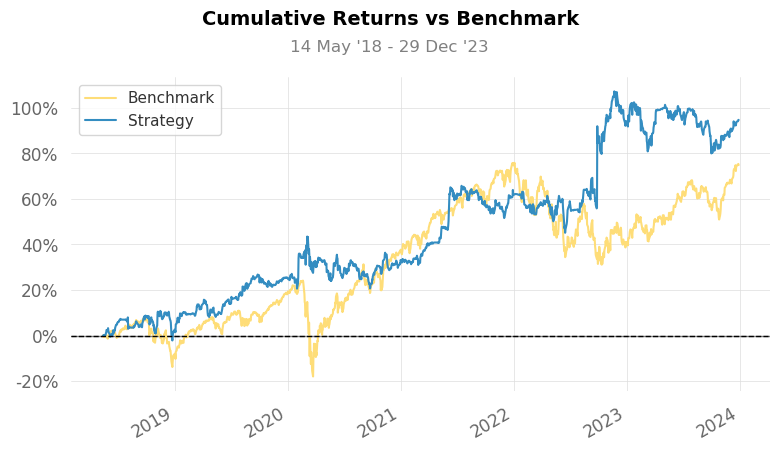

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


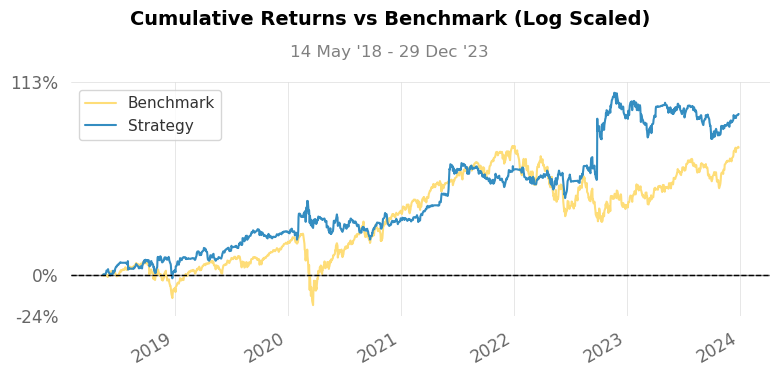

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


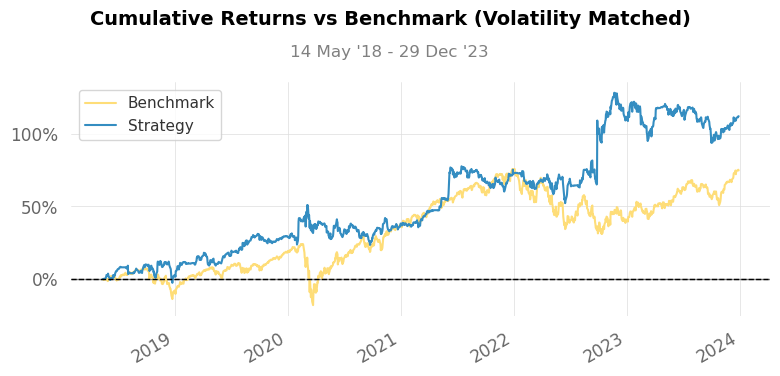

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


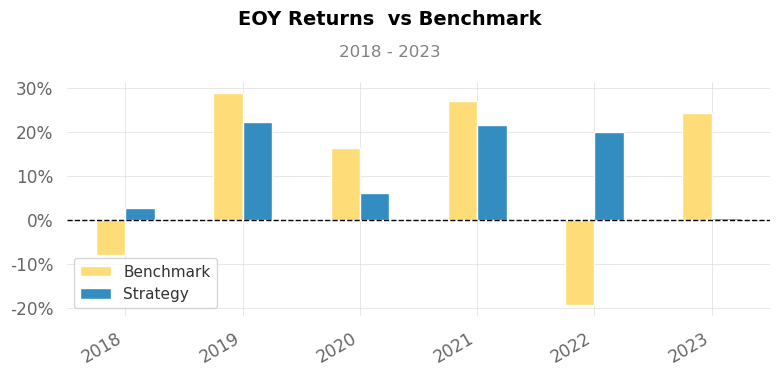

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


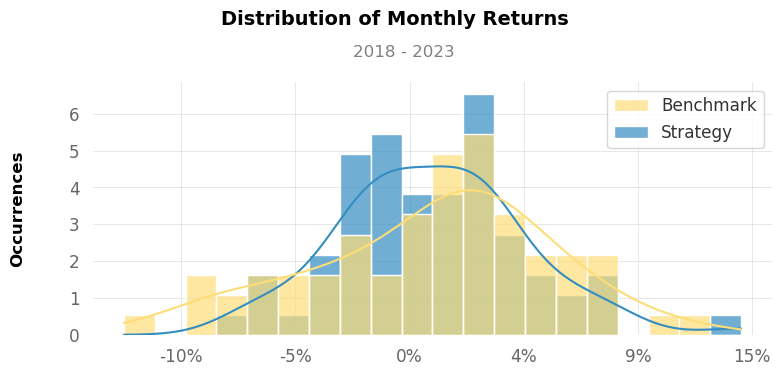

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


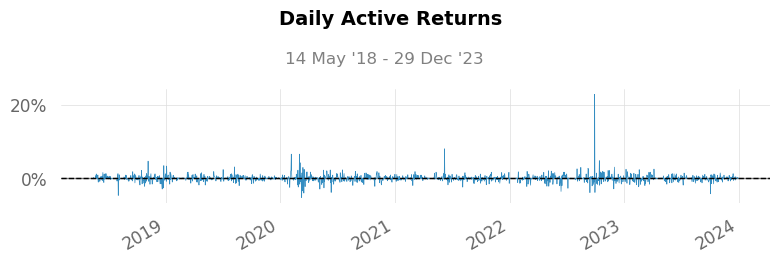

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


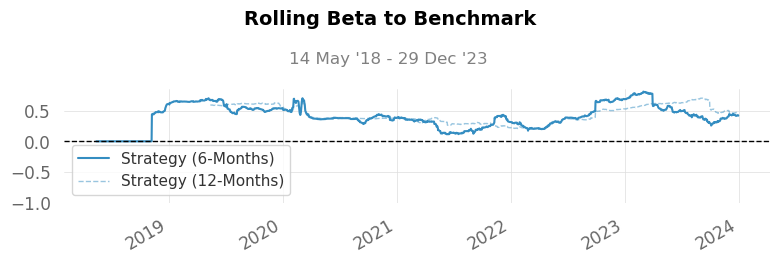

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


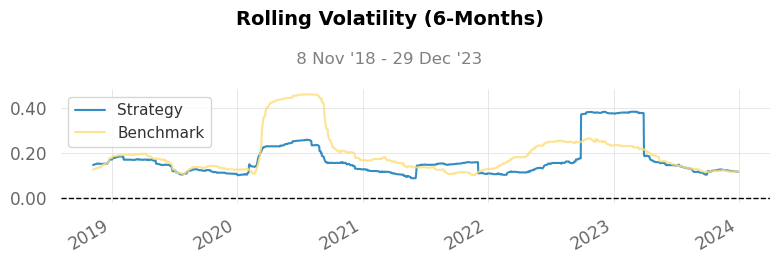

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


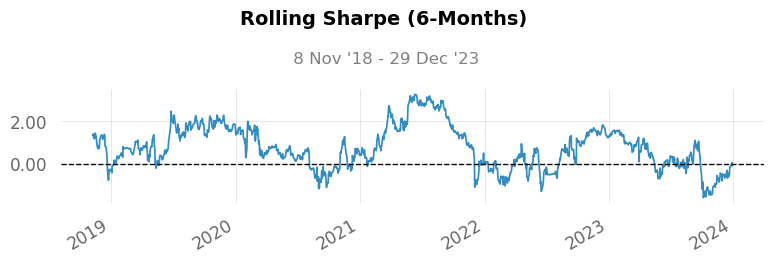

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


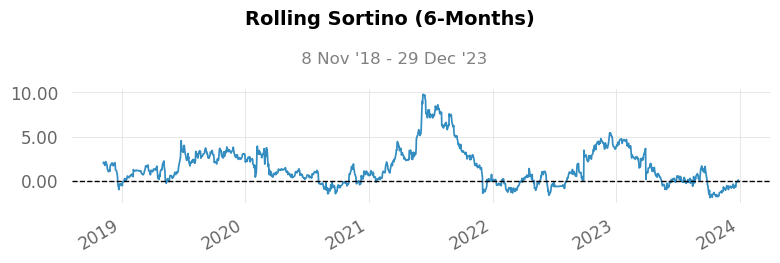

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


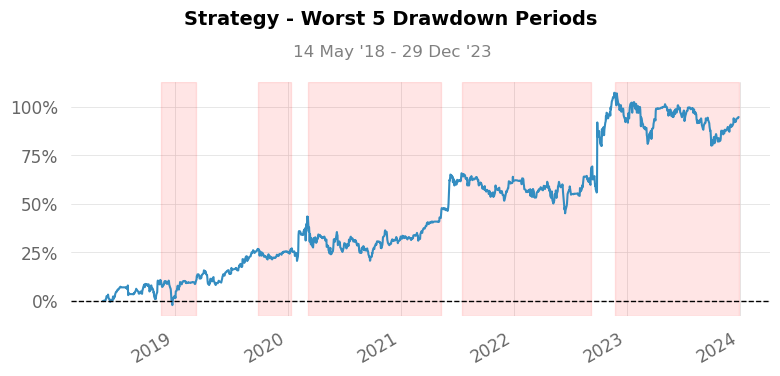

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


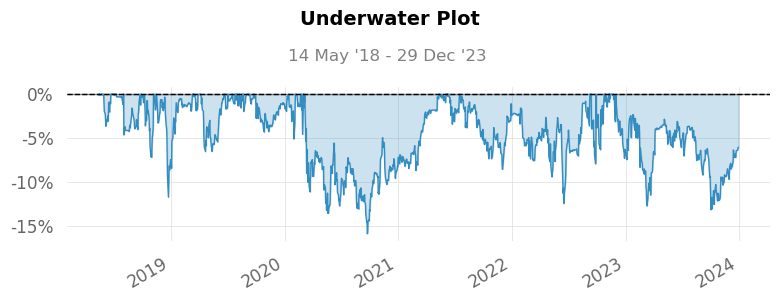

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


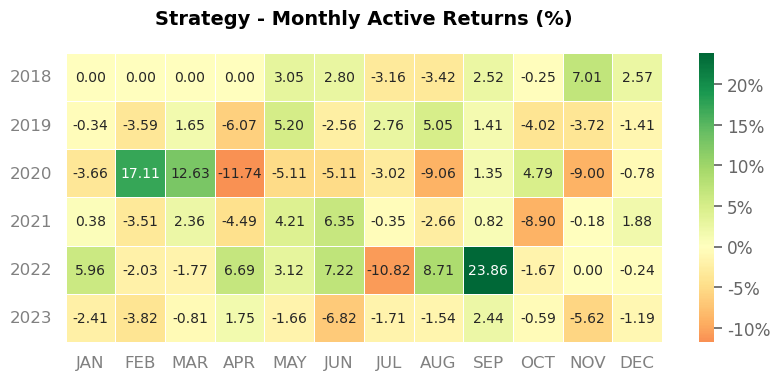

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


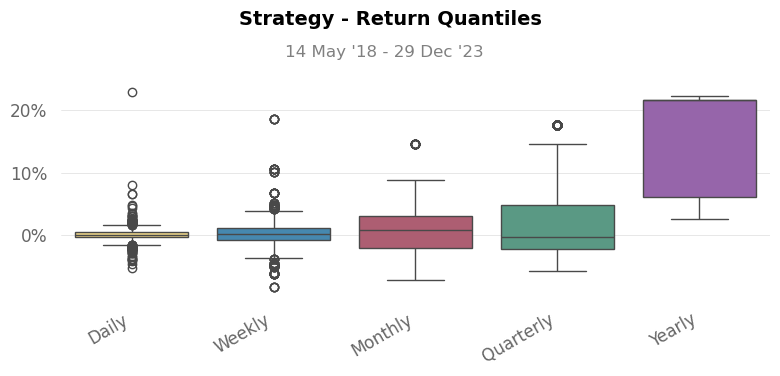

In [47]:
start = result.index[0]
end = result.index[-1]
# Using S & P 500 Index as Benchmark
benchmark = yf.download('^GSPC', start=start, end=end)['Adj Close'].pct_change()
result.index = pd.to_datetime(result.index).tz_convert(None)
result.index = benchmark.index    
qs.reports.full(result['returns'], benchmark = benchmark, match_dates=True, figsize=(8, 4), df = result)

# Comments on Tearsheet results
###
1. Cumulative Returns: As we can see my strategy gets more total return (94.73%) than benchmark S & P 500 index (74.87%).
2. CAGR: My strategy has more annual average return (8.52%) than benchmark (7.09%).
3. Sharpe Ratio: Strategy generate more return per risk ratio (0.74) than benchmark (0.58).
4. Annual Volatility: Strategy is less volatile (18.07%) than benchmark (20.81%).
5. Drawdown: Max Drawdown of strategy is -15.88% which is half of the benchmark's maximum Drawdown (-33.92%). And also it took less than half of benchmark longest drawdown period to overcome this drawdown. 
    Longest DD days: Strategy (432 days) and Benchmark (725 days).
###

# Improving Strategy Result

###
This strategy yields better and steadier returns, even in the face of various market crises, such as the COVID-19 period. It boasts a Sharpe ratio of 0.74. To enhance results, consider increasing the frequency of stock purchases or extending the consecutive buying days. 

Parameters like buying percentage, maximum consecutive buying days, and RSI period should be optimized to achieve better outcomes. Techniques such as brute force, machine learning approaches, or optimizers like SLSQP can be employed for this purpose. 

Another viable approach is to diversify beyond mean-reverting techniques, as the market is not always in a mean-reverting stage. Incorporating trend-following indicators like MACD can help adapt to different market conditions. 

Additionally, exploring the Kalman Filter, a tool for estimating joint probability distributions over variables in each frame, presents another avenue for forecasting stock price movements. This strategy, enriched with these considerations, is worth experimenting with.
###